# Prediction of Involvement of Drunk Drivers in Fatal Highway Crashes
## Machine Learning

### Chester Hitz | Springboard Data Science Career Track | Capstone II

Following a pivot from my original capstone idea, I am trying to identify the involvement of at least one drunk driver in a fatal car crash using the extensive dataset from the Fatality Analysis Reporting System. This is a massive dataset, but I am trying to predict based on a limited number of variables, namely:

* Timing: Time of day and day of week.
* Crash events: Crash events: Contained within the three CF (crash factor), five PCRASH (precrash) and MANCOL (manner of collision) variables is a collection of categorical variables that describe events in every crash, with category describing a different event. 
* Various other factors: Involvement of speeding and road type.

Various insights about the data can be read about in the [EDA portion](https://github.com/cwhitz/Springboard-Capstone-1/blob/master/Accidents%20EDA.ipynb) of this capstone. The aim of this portion is to select, tune, and test the best machine learning algorithm to attain the most accurate predictions of the target variable, DRUNK_INV, which indicates the involvement of at least one drunk driver.

To start, I import the standard libraries plus some sklearn libraries for preprocessing and metrics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

# general sklearn tools for preprocessing and metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, r2_score

# data import
df = pd.read_csv('Accidents_ML.csv')

# validate data load
print(df.shape)
print(df.info())

(224992, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224992 entries, 0 to 224991
Data columns (total 24 columns):
Unnamed: 0        224992 non-null int64
index             224992 non-null int64
DRUNK_INV         224992 non-null bool
HOUR              224992 non-null int64
DAY_WEEK          224992 non-null int64
LGT_COND          224992 non-null int64
CF1               224992 non-null int64
CF2               224992 non-null int64
CF3               224992 non-null int64
P_CRASH1          224992 non-null int64
P_CRASH2          224992 non-null int64
P_CRASH3          224992 non-null int64
PCRASH4           224992 non-null int64
PCRASH5           224992 non-null int64
MAN_COLL          224992 non-null int64
VSPD_LIM          215483 non-null float64
TRAV_SP           83159 non-null float64
FATALS            224992 non-null int64
ROUTE             224992 non-null int64
PERMVIT           224992 non-null float64
corrected_HOUR    224992 non-null int64
Weekend           224992 non-nul

## Data Preprocessing
The first task is to make the many categorical variables in the dataset more expressive and machine-readable. Currently the variables are encoded with integers, each representing a different category of something. However, those integers are merely symbolic and have no linear nor ordinal relationship to one and other. Therefore, it is easier for sklearn's models to read the categories when the categories are fleshed out to new columns with binary values, showing whether that particular record is in a certain category (represented by a 1) or not (0). This ends up creating *n* columns, where *n* is the total number of unique categories in the column. 

Below, nine categorical columns are transformed into binary representation via the use of sklearn's OneHotEncoder().

In [2]:
cat_features = ['CF1','CF2','CF3','P_CRASH1','P_CRASH2','P_CRASH3','PCRASH4','PCRASH5', 'ROUTE','MAN_COLL']
df.drop(['road_type','Unnamed: 0','index','HOUR'], axis=1, inplace=True)

n_cols=df.shape[1]

enc = OneHotEncoder(sparse=False)

# this code block loops through the specified categorical features in the dataframe and performs
# an OHE transformation on them, then concats them back to the dataframe
for feature in cat_features:
    mtx = df[feature].values.reshape(len(df), 1)
    mtx = enc.fit_transform(mtx)
    
    c_names= [feature+'_'+str(enc.active_features_[x]) for x in range(mtx.shape[1])]
    mtx_df = pd.DataFrame(mtx, index=df.index, columns=c_names)
    df = df.drop(feature, axis=1)
    df = pd.concat([df, mtx_df], axis=1)
    
'n columns added to dataframe: ' + str(df.shape[1] - n_cols)

'n columns added to dataframe: 177'

Note that the column names have the integer keys they represent preserved via code on line 14. 

The next step is to try some different models on the data, but first I split the data into training and test groups.

In [3]:
# split off the target array from the data, then split train/test data at customary 80-20 ratio
y = df['DRUNK_INV']
X = df.drop(['DRUNK_INV','VSPD_LIM','TRAV_SP','OverSpeedLimit'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=32, train_size=.8, test_size=.2)

## Logistic Regression

The first model type to examine is Logisitic Regression, which is the classification variant of linear regression and compares output values against a threshold. I will start by defining a common model testing and scoring function, then pass a LogisticRegressor estimator object to it.

In [4]:
from sklearn.linear_model import LogisticRegression

def common_pipeline(model, model_return=False):
    m = model.fit(X_train, y_train)
    train_accuracy = m.score(X_train, y_train)
    test_accuracy = m.score(X_test, y_test)

    print("Accuracy | Training : ", accuracy_score(y_train, m.predict(X_train)))
    print("Accuracy | Test     : ", accuracy_score(y_test, m.predict(X_test)))

    if model_return:
        return m

lgr = common_pipeline(LogisticRegression(), model_return=True)

Accuracy | Training :  0.758357269449
Accuracy | Test     :  0.761239138648


As the test and training scores are roughly equal, it looks like there may be a bit of underfitting. Increasing the *C* parameter, which determines the strength of regularization in the data, may be a solution to this. To test, I run a GridSearchCV function to test five different values of C.

In [5]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C':[.01,.1,1,10,100]}

grid= GridSearchCV(LogisticRegression(), param_grid, cv=5)

grid.fit(X,y)

print("Best Score :", grid.best_score_)
print("Best parameters :", grid.best_params_)

Best Score : 0.758560304366
Best parameters : {'C': 0.1}


It turns out that the default value of C, 1, is actually the best for this model. Lower values of C correspond to a less complex model, while higher values of C are more complex. A value of 1 for C is right in the middle, so we can say our data benefits from a mildly complex model. Before moving on to testing the next type of model, let's look at a Confusion Matrix to see where the model is accurately and inaccurately predicting.

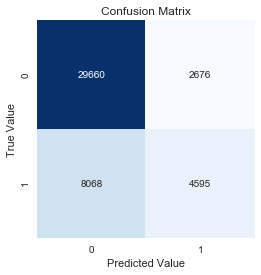

In [6]:
lgr_predictions = lgr.predict(X_test)

# I will be making a few confusion matrices, so it is good to create a function for them now
def c_mtx_plot(correct, predictions):
    c_mtx = confusion_matrix(correct, predictions)
    sns.heatmap(c_mtx, square=True, annot=True, cbar=False, fmt='g', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Value')
    plt.ylabel('True Value')
    
c_mtx_plot(y_test, lgr_predictions)

The model is predicting more false negatives (prediction: sober; reality: inebriated) than true positives, which is not good. However it is predicting most of the true negatives correctly. Given the sparseness of positive values in the target array, it makes sense that the model is struggling to identify when they are present.

## Linear SVC

Another linear model to test is the Linear Support Vector Classifier (LinearSVC). LinearSVCs are similar to Logistic classifiers in the way they determine a decision boundary across multiple dimensions, but the method of determining that boundary is focused on maximizing the margin between the points closest to that boundary. The hyperparameter *C* softens that boundary and prevents overfitting of the data. Below I call an LinearSVC estimator instance, and then try several values for C outside the default using CVGridSearch.

In [7]:
from sklearn.svm import LinearSVC

common_pipeline(LinearSVC())

Accuracy | Training :  0.755179368087
Accuracy | Test     :  0.757816840374


In [8]:
param_grid = {'C':[.01,.1,1,10,100]}

grid= GridSearchCV(LinearSVC(), param_grid)

grid.fit(X,y)

print("Best Score :", grid.best_score_)
print("Best parameters :", grid.best_params_)

Best Score : 0.757089140947
Best parameters : {'C': 0.1}


The baseline and GridSearchCV results are not very promising, so it seems that even with hyperparametric tuning that LinearSVC is not the right model for this data.

## Decision Tree and Random Forest Classifiers

The next models to try are the decision tree classifiers, which build a "tree" of decision points and nodes representing final decisions. I start with simple DecisionTreeClassifier to determine a baseline for improvement.

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

dtc = common_pipeline(DecisionTreeClassifier(random_state=42), model_return=True)

Accuracy | Training :  0.970065502547
Accuracy | Test     :  0.74599435543


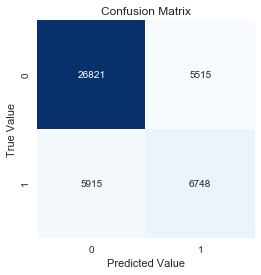

In [10]:
c_mtx_plot(y_test, dtc.predict(X_test))

The decision tree seems to be overfitting to the training data, resulting in lower test accuracy relative to training accuracy. Using an ensemble method, RandomForestClassifier, might have a better accuracy rate than just building a single decision tree, as it builds an ensemble of trees based off various bootstrap subsets of the data, then finds the average between them. A RandomForestClassifier is trained below to establish a baseline, and it scores notably higher than any previous model.

In [11]:
rfc = common_pipeline(RandomForestClassifier(random_state=42), model_return=True)

Accuracy | Training :  0.95585383876
Accuracy | Test     :  0.773950532234


Again, another small improvement but I overfitting could still be improved. To do this, I set up a grid search with two parameters - the mamimum depth of the decision trees in the forest (max_depth), and the number maximum number of features for used in each bootstrap (max_features). The current max_features is the square root of the number of features in the dataset. To prevent overfitting, I am going to try to tune that down.

In [12]:
param_grid = {'max_depth':np.arange(5,25,5),
             'max_features':[None, 'sqrt', 'log2', .5]}

grid= GridSearchCV(RandomForestClassifier(random_state=42), param_grid).fit(X, y)

print(grid.best_score_)
print(grid.best_params_)

rfc_best = grid.best_estimator_

common_pipeline(rfc_best)

0.786147951927
{'max_depth': 10, 'max_features': 0.5}
Accuracy | Training :  0.795936508642
Accuracy | Test     :  0.791173137181


As we can see here, more improvement and less overfitting. The training and test scores are more balanced with a max depth of 20 and with half the features being considered. Both these are higher than a normal use case for random forest classifiers, but that makes sense given the nature of the dataset. 

One appreciable aspect of the decision tree classifier is how stunningly interpretable it is in context of this case, especially when it comes to the crash factors and pre-crash movements. As covered in the EDA section of my capstone, the pre-crash movement variables describe a story of a crash through categorical variables, where each of the five variables (P_CRASH1 - P_CRASH5) is a different step that led to the crash. Therefore branches of the decision tree may split at each action. For example, the decision tree learns that values like 1 in P_CRASH3, indicating that no avoidance maneuver was taken by the driver to avoid an accident, mean the driver was more likely to be impaired. 

In [13]:
cross_val_score(rfc_best, X, y, cv=5, scoring='accuracy')

array([ 0.79206205,  0.7869286 ,  0.7842841 ,  0.79201298,  0.7813632 ])

Examining the feature importances can provide insight into what features are most important in the decision tree ensemble. In this case, I reverse the processing done in my preprocessing step with OneHotEncoder to aggregate the feature importances of each categorical variable.

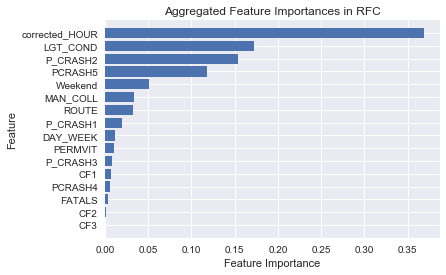

In [14]:
# create series of top features, index set to those features
rfc_top_features = pd.Series(rfc_best.feature_importances_, index=X_train.columns).sort_values()

# create seperate series to aggregate
rfc_top_features_agg = rfc_top_features.copy()

# aggregate categorical features based on common column titles
for cat in cat_features:
    all_sub_features = rfc_top_features[[x for x in list(rfc_top_features.index) if cat in x]]
    rfc_top_features_agg[cat] = np.sum(all_sub_features)
    # drop subcategories
    rfc_top_features_agg.drop(all_sub_features.index, axis=0, inplace=True)

# sort values
rfc_top_features_agg.sort_values(inplace=True)

# plot values
n_features = rfc_top_features_agg.shape[0]
plt.barh(range(n_features), rfc_top_features_agg.values, align='center')
plt.yticks(np.arange(n_features), rfc_top_features_agg.index)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Aggregated Feature Importances in RFC")
plt.ylim(-1, n_features)
plt.show()

The feature importances in this case are not too different from the analysis of coefficients in a linear model. As expected from our EDA, corrected_HOUR (which refers to the number of hours since 7AM) and LGT_COND (Light conditions, closely correlated to HOUR) have the most decision power in the decision trees, but no one feature has the majority. 

Beyond that, aggregating the values for each subcategory of the categorical events lets us see how important each of those categories are as a whole, information that might otherwise be lost. We can see how Pre-Crash Event 2 - which identifies the attribute that best describes the critical event which made the crash imminent - is the most important of the categorical variables. We can use the non-aggregated series to see specifically which events are the most important. Let's look at the top ten subcategories within P_CRASH2 and information from the analytical manual.

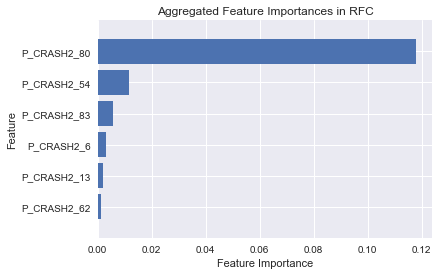

In [28]:
top_6_PC2_features = rfc_top_features[[x for x in rfc_top_features.index if 'P_CRASH2' in x]].sort_values(ascending=False)[:6]
top_6_PC2_features.sort_values(ascending=True, inplace=True)
plt.barh(range(6), top_6_PC2_features.values, align='center')
plt.yticks(np.arange(6), top_6_PC2_features.index)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Aggregated Feature Importances in RFC")
plt.ylim(-1, 6)
plt.show()

The top five of these represent the following (keep in mind this can refer to any car in the crash, not just the inebriated driver):
* 80: Pedestrian in roadway
* 54: Vehicle travelling on wrong side of road
* 83: Cyclist in roadway
* 6: Travelling too fast for conditions
* 13: Off the edge of the road on the right side.
* 62: Vehicle travelling over left line from opposite direction.

These all seem like actions that a drunk driver would either do or have trouble dealing with. It makes sense then that they are the some of the most important decision points in the forest classifier, and serves to highlight the interpretability of the decision tree in this case.

### Gradient Boosting Classifiers

If we take a look at the confusion matrix produced by the best RFC estimator, we can see that true positives are now exceeding false positives, which is excellent. 

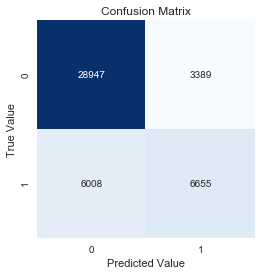

In [16]:
c_mtx_plot(y_test, rfc_best.predict(X_test))

However, false positives are still higher than we'd like. In the interest of improving this further, I am going to try using a gradient boosting classifier, which like RandomForestClassifier is an ensemble of decision trees, but constructed differently. Trees for specific parts of the data are added in iteration to the model, creating a combination of many simple models. One important parameter of GBCs is the learning rate, which controls how strongly each tree tries to correct the mistakes of the trees added prior to it, allowing more complex models. Since I have already found this dataset benefits from a more complex model, I will first train and test a baseline model, then try three different values for learning rate, along with the previously identified best parameters.

Accuracy | Training :  0.789552927058
Accuracy | Test     :  0.79072868286


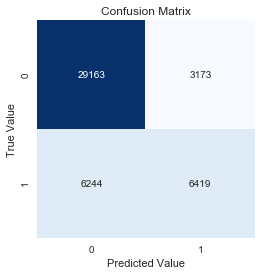

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = common_pipeline(GradientBoostingClassifier(random_state=42), model_return=True)
c_mtx_plot(y_test, gbc.predict(X_test))

In [18]:
param_grid = {'learning_rate':[.1,.5,1]}

grid= GridSearchCV(GradientBoostingClassifier(random_state=42, max_features=.5, max_depth=10), param_grid).fit(X, y)

In [19]:
print(grid.best_score_)
print(grid.best_params_)

gbc_best = grid.best_estimator_

0.788894716257
{'learning_rate': 0.1}


Finally, I will apply the best estimator pulled from grid serach and use it to predict the holdout set, along with a confusion matrix.

Accuracy | Training :  0.822798664393
Accuracy | Test     :  0.797684392987


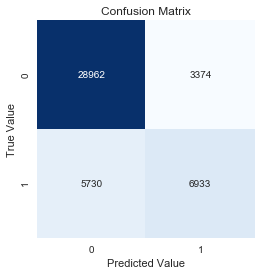

In [20]:
gbc = common_pipeline(gbc_best)
c_mtx_plot(y_test, gbc_best.predict(X_test))

This Gradient Boosted Classifier loaded with the best parameters from GridSearchCV is performing the best of any estimator tested thus far. True positives finally are surpassing false positives by almost 1200 counts. 

## Conclusion

What has been built and tuned here from my data is a classification estimator that can predict whether or not a driver was drunk in an accident based on the day of the week, time of day, the actions taken by the drivers, and the number of people involved in the crash. The accuracy of these predictions is just under 80%, which is not perfect, but can be used to guide investigations, public health decisions, and possibly civil safety engineering. 